# SY 클래스 라벨 의미 검증 및 시각화 EDA
SY(낙상) 클래스 샘플의 영상, 이미지, 센서 시퀀스를 시각화하여 실제 낙상 동작이 맞는지 육안 검증합니다.

## 1. 필요 라이브러리 임포트
데이터 분석 및 시각화를 위한 pandas, numpy, matplotlib, cv2, tqdm, scipy.signal(find_peaks) 등을 임포트합니다.

In [7]:
# 필요 라이브러리 임포트
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from scipy.signal import find_peaks

plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

## 2. SY 클래스 샘플 목록 추출 및 경로 생성
SY(낙상) 클래스 샘플만 추출하고, 영상/이미지/센서 파일 경로를 생성합니다.

In [8]:
# SY 클래스 샘플 목록 추출 및 경로 생성
clean_csv_path = '../EDA/train_clean.csv'
df_clean = pd.read_csv(clean_csv_path)

# SY 클래스만 추출
sy_samples = df_clean[df_clean['class'] == 'Y/SY'].copy()
print(f'SY 샘플 수: {len(sy_samples)}')

def get_sensor_path(sample_id):
    return f"../data/train/raw/sensor/Y/SY/{sample_id}/{sample_id}.csv"
def get_video_path(sample_id):
    return f"../data/train/raw/video/Y/SY/{sample_id}/{sample_id}.mp4"
def get_image_dir(sample_id):
    return f"../data/train/raw/image/Y/SY/{sample_id}/"

sy_samples['sensor_path'] = sy_samples['sample_id'].apply(get_sensor_path)
sy_samples['video_path'] = sy_samples['sample_id'].apply(get_video_path)
sy_samples['image_dir'] = sy_samples['sample_id'].apply(get_image_dir)

sy_samples.head()

SY 샘플 수: 1856


,sample_id,class,image_dir,video_dir,sensor_dir,sensor_path,video_path
2272,02091_H_A_SY_C7,Y/SY,../data/train/raw/image/Y/SY/02091_H_A_SY_C7/,../data/train/raw/video/Y/SY/02091_H_A_SY_C7,../data/train/raw/sensor/Y/SY/02091_H_A_SY_C7,../data/train/raw/sensor/Y/SY/02091_H_A_SY_C7/...,../data/train/raw/video/Y/SY/02091_H_A_SY_C7/0...
2273,00022_H_A_SY_C8,Y/SY,../data/train/raw/image/Y/SY/00022_H_A_SY_C8/,../data/train/raw/video/Y/SY/00022_H_A_SY_C8,../data/train/raw/sensor/Y/SY/00022_H_A_SY_C8,../data/train/raw/sensor/Y/SY/00022_H_A_SY_C8/...,../data/train/raw/video/Y/SY/00022_H_A_SY_C8/0...
2274,02107_H_A_SY_C8,Y/SY,../data/train/raw/image/Y/SY/02107_H_A_SY_C8/,../data/train/raw/video/Y/SY/02107_H_A_SY_C8,../data/train/raw/sensor/Y/SY/02107_H_A_SY_C8,../data/train/raw/sensor/Y/SY/02107_H_A_SY_C8/...,../data/train/raw/video/Y/SY/02107_H_A_SY_C8/0...
2275,02211_H_A_SY_C7,Y/SY,../data/train/raw/image/Y/SY/02211_H_A_SY_C7/,../data/train/raw/video/Y/SY/02211_H_A_SY_C7,../data/train/raw/sensor/Y/SY/02211_H_A_SY_C7,../data/train/raw/sensor/Y/SY/02211_H_A_SY_C7/...,../data/train/raw/video/Y/SY/02211_H_A_SY_C7/0...
2276,00112_H_A_SY_C1,Y/SY,../data/train/raw/image/Y/SY/00112_H_A_SY_C1/,../data/train/raw/video/Y/SY/00112_H_A_SY_C1,../data/train/raw/sensor/Y/SY/00112_H_A_SY_C1,../data/train/raw/sensor/Y/SY/00112_H_A_SY_C1/...,../data/train/raw/video/Y/SY/00112_H_A_SY_C1/0...


## 3. SY 샘플 센서/영상/이미지 시각화
SY 샘플 중 일부를 선택하여 센서 시퀀스, 영상 프레임, 이미지 샘플을 시각화합니다.

샘플: 00162_H_A_SY_C2


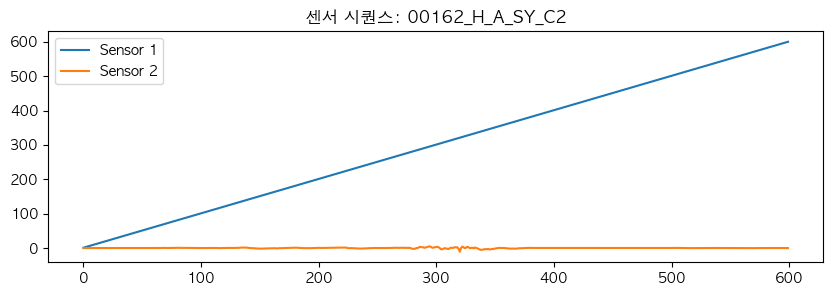

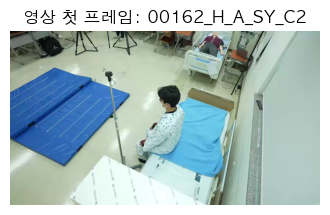

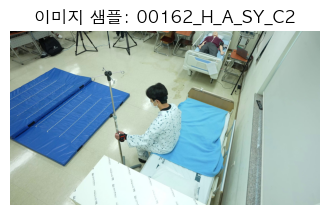

----------------------------------------
샘플: 02423_H_A_SY_C7


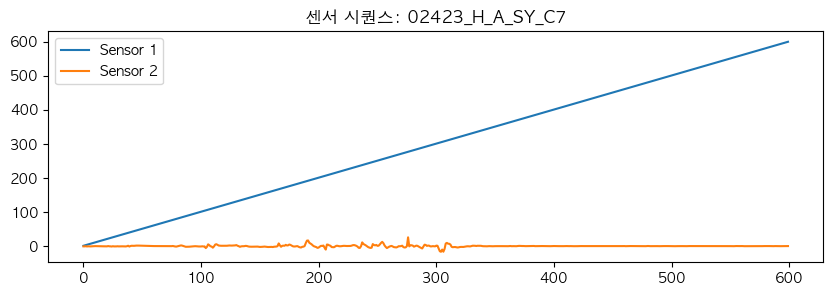

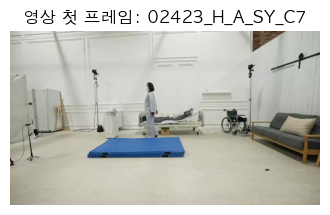

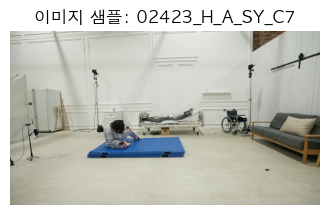

----------------------------------------
샘플: 02442_H_A_SY_C2


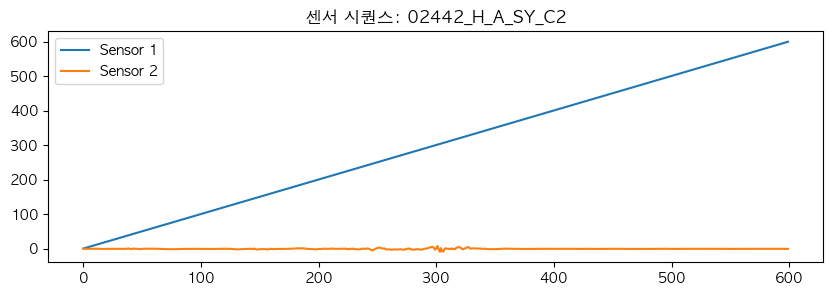

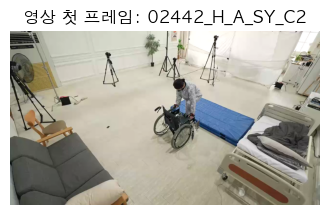

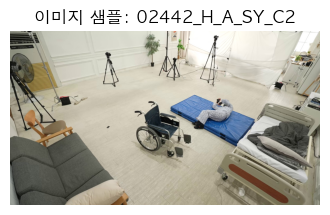

----------------------------------------


In [9]:
# SY 샘플 시각화 함수
import random
import glob

# 샘플 3개 랜덤 선택
sy_vis_samples = sy_samples.sample(n=3, random_state=42)

for idx, row in sy_vis_samples.iterrows():
    print(f"샘플: {row['sample_id']}")
    # 센서 시퀀스 시각화
    if os.path.exists(row['sensor_path']):
        df_sensor = pd.read_csv(row['sensor_path'])
        plt.figure(figsize=(10,3))
        plt.plot(df_sensor.iloc[:,0], label='Sensor 1')
        if df_sensor.shape[1] > 1:
            plt.plot(df_sensor.iloc[:,1], label='Sensor 2')
        plt.title(f"센서 시퀀스: {row['sample_id']}")
        plt.legend()
        plt.show()
    else:
        print("센서 파일 없음")
    # 영상 프레임 시각화 (첫 프레임)
    if os.path.exists(row['video_path']):
        cap = cv2.VideoCapture(row['video_path'])
        ret, frame = cap.read()
        if ret:
            plt.figure(figsize=(4,4))
            plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            plt.title(f"영상 첫 프레임: {row['sample_id']}")
            plt.axis('off')
            plt.show()
        else:
            print("영상 프레임 읽기 실패")
        cap.release()
    else:
        print("영상 파일 없음")
    # 이미지 시각화 (폴더 및 하위폴더 내 첫 이미지, glob 사용)
    if os.path.exists(row['image_dir']):
        patterns = ['**/*.jpg', '**/*.JPG']
        img_files = []
        for pat in patterns:
            img_files += glob.glob(os.path.join(row['image_dir'], pat), recursive=True)
        if img_files:
            img = cv2.imread(img_files[0])
            if img is not None:
                plt.figure(figsize=(4,4))
                plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                plt.title(f"이미지 샘플: {row['sample_id']}")
                plt.axis('off')
                plt.show()
            else:
                print("이미지 읽기 실패")
        else:
            print("이미지 없음")
    else:
        print("이미지 폴더 없음")
    print('-'*40)


## 4. SY 샘플 전체 통계 및 품질 분석
SY 샘플의 센서 길이, 영상 프레임 수, 이미지 개수 등 분포와 품질을 요약합니다.

100%|██████████| 1856/1856 [00:12<00:00, 148.16it/s]



센서 길이 분포:
count    1856.0
mean      100.0
std         0.0
min       100.0
25%       100.0
50%       100.0
75%       100.0
max       100.0
Name: sensor_length, dtype: float64
영상 프레임 수 분포:
count    1856.000000
mean      100.620690
std         9.436208
min       100.000000
25%       100.000000
50%       100.000000
75%       100.000000
max       244.000000
Name: video_length, dtype: float64
이미지 개수 분포:
count    1856.0
mean       10.0
std         0.0
min        10.0
25%        10.0
50%        10.0
75%        10.0
max        10.0
Name: image_count, dtype: float64


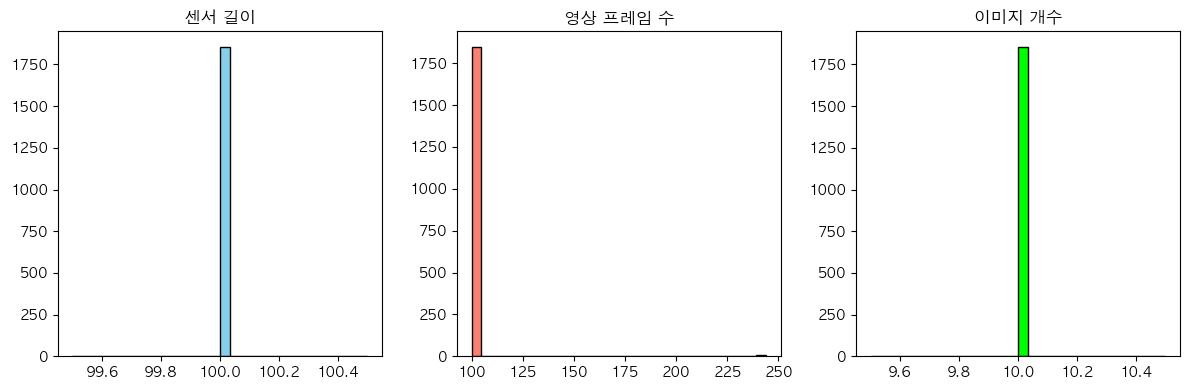

In [12]:
from tqdm import tqdm
import numpy as np
import glob

sensor_lengths = []
video_lengths = []
image_counts = []

for idx, row in tqdm(sy_samples.iterrows(), total=len(sy_samples)):
    # 센서 길이
    if os.path.exists(row['sensor_path']):
        try:
            df_sensor = pd.read_csv(row['sensor_path'])
            sensor_lengths.append(len(df_sensor))
        except Exception as e:
            print(f"센서 파일 읽기 실패: {row['sensor_path']} - {e}")
            sensor_lengths.append(np.nan)
    else:
        print(f"센서 파일 없음: {row['sensor_path']}")
        sensor_lengths.append(np.nan)
    # 영상 프레임 수
    if os.path.exists(row['video_path']):
        try:
            cap = cv2.VideoCapture(row['video_path'])
            frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            video_lengths.append(frame_count)
            cap.release()
        except Exception as e:
            print(f"영상 파일 읽기 실패: {row['video_path']} - {e}")
            video_lengths.append(np.nan)
    else:
        print(f"영상 파일 없음: {row['video_path']}")
        video_lengths.append(np.nan)
    # 이미지 개수 (하위폴더 포함, 다양한 확장자)
    if os.path.exists(row['image_dir']):
        try:
            patterns = ['**/*.jpg', '**/*.JPG']
            img_files = []
            for pat in patterns:
                img_files += glob.glob(os.path.join(row['image_dir'], pat), recursive=True)
            image_counts.append(len(img_files))
        except Exception as e:
            print(f"이미지 폴더 읽기 실패: {row['image_dir']} - {e}")
            image_counts.append(np.nan)
    else:
        print(f"이미지 폴더 없음: {row['image_dir']}")
        image_counts.append(np.nan)

sy_samples['sensor_length'] = sensor_lengths
sy_samples['video_length'] = video_lengths
sy_samples['image_count'] = image_counts

print('센서 길이 분포:')
print(sy_samples['sensor_length'].describe())
print('영상 프레임 수 분포:')
print(sy_samples['video_length'].describe())
print('이미지 개수 분포:')
print(sy_samples['image_count'].describe())

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.hist(sy_samples['sensor_length'].dropna(), bins=30, color='skyblue', edgecolor='black')
plt.title('센서 길이')
plt.subplot(1,3,2)
plt.hist(sy_samples['video_length'].dropna(), bins=30, color='salmon', edgecolor='black')
plt.title('영상 프레임 수')
plt.subplot(1,3,3)
plt.hist(sy_samples['image_count'].dropna(), bins=30, color='lime', edgecolor='black')
plt.title('이미지 개수')
plt.tight_layout()
plt.show()


In [11]:
# 센서 csv를 600 → 100 rows로 다운샘플링 (6개씩 평균)
import pandas as pd
import glob

# 예시: SY 센서 경로 리스트 (필요시 전체 경로로 확장)
sensor_csvs = sy_samples['sensor_path'].tolist()

for csv_path in sensor_csvs:
    if not os.path.exists(csv_path):
        print(f"[경고] 파일 없음: {csv_path}")
        continue
    try:
        df = pd.read_csv(csv_path)
        # 6개씩 평균내서 100개로 다운샘플링
        df_down = df.groupby(df.index // 6).mean()
        df_down = df_down.reset_index(drop=True)
        df_down.to_csv(csv_path, index=False)
        print(f"다운샘플링 완료: {csv_path} → {len(df)} → {len(df_down)} rows")
    except Exception as e:
        print(f"[에러] {csv_path}: {e}")

다운샘플링 완료: ../data/train/raw/sensor/Y/SY/02091_H_A_SY_C7/02091_H_A_SY_C7.csv → 600 → 100 rows
다운샘플링 완료: ../data/train/raw/sensor/Y/SY/00022_H_A_SY_C8/00022_H_A_SY_C8.csv → 600 → 100 rows
다운샘플링 완료: ../data/train/raw/sensor/Y/SY/02107_H_A_SY_C8/02107_H_A_SY_C8.csv → 600 → 100 rows
다운샘플링 완료: ../data/train/raw/sensor/Y/SY/02211_H_A_SY_C7/02211_H_A_SY_C7.csv → 600 → 100 rows
다운샘플링 완료: ../data/train/raw/sensor/Y/SY/00112_H_A_SY_C1/00112_H_A_SY_C1.csv → 600 → 100 rows
다운샘플링 완료: ../data/train/raw/sensor/Y/SY/02922_H_B_SY_C5/02922_H_B_SY_C5.csv → 600 → 100 rows
다운샘플링 완료: ../data/train/raw/sensor/Y/SY/02131_H_A_SY_C2/02131_H_A_SY_C2.csv → 600 → 100 rows
다운샘플링 완료: ../data/train/raw/sensor/Y/SY/02264_H_A_SY_C3/02264_H_A_SY_C3.csv → 600 → 100 rows
다운샘플링 완료: ../data/train/raw/sensor/Y/SY/00190_H_A_SY_C8/00190_H_A_SY_C8.csv → 600 → 100 rows
다운샘플링 완료: ../data/train/raw/sensor/Y/SY/00645_H_D_SY_C2/00645_H_D_SY_C2.csv → 600 → 100 rows
다운샘플링 완료: ../data/train/raw/sensor/Y/SY/02637_H_A_SY_C1/02637_H_A_SY_C